In [1]:
import sys
# sys.path.insert(0,'C:/Users/annal/OneDrive/Documents/python3.8/pygplates_rev28_python38_win64')
sys.path.insert(0,'/Users/omer/Documents/pygplates_rev18_python27_MacOS64')
sys.path.insert(0,'/Applications/GMT-6.0.0.app/Contents/Resources')
import pygplates
import matplotlib.pyplot as plt
import sys
import numpy as np
from call_system_command import call_system_command
%matplotlib inline
import pandas as pd

In [2]:
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/savani/Tomography'


kimberlite_dir = "/Users/omer/Documents/Data_Tomography_Geology"

#Annalise, note that in my test script:
#make-and-export-reconstructed-locations-at-present-day-kimberlites-for-annalise.ipynb
#the output file does not contain information about the maximum age (agemax)
#you should change this using the script variables so that that the name
#of the output file is, for example, is T18_centroids_640Ma_2017NNR_plateIDs.gpml
#that way the name should automatically change when you change the period of interest
#(which we will want to do)

kimberlite_file = "%s/T18_centroids_2017NNR_plateIDs.gpml" %(kimberlite_dir)

point_features = pygplates.FeatureCollection(kimberlite_file)

In [2]:
# generic function to sample grids using grdtrack and read results
def sample_using_gmt(grdfile, point_lons, point_lats):

        dataout = np.vstack((np.asarray(point_lons),np.asarray(point_lats))).T

        np.savetxt('tmp.txt',dataout)
        # Note -nn forces nearest neighbour interpolation
        call_system_command(['gmt','grdtrack','tmp.txt','-G{:s}'.format(grdfile), '-fg','-nn','-V','>', 'tmp_interp.txt'])
        G=[]
        with open('tmp_interp.txt') as f:
            for line in f:
                if line[0] == '>':
                    continue
                else:
                    tmp = line.split()
                    G.append(float(tmp[2]))

        f.close()
        return np.array(G)

# SAVANI

In [8]:
root='/Users/omer/Downloads/Supplement/Reconstructions/M21/'
here= '/Users/omer/Documents/Programming/PyGplates/'
# rotation_file1 = root + '1000-410_rotations-NNR.rot'
# rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
# rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file = root + '1000_0_rotfile_Merdith_et_al.rot'

rotation_model = pygplates.RotationModel(rotation_file)

f=open('/Users/omer/Documents/Data_Tomography_Geology/savani_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points=[]
filenames = []
vs_at_p_all_depths=[]
for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths=[]
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths.append(vs_at_p_d)
        
    plt.plot(vs_at_p_all_depths,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)

    
#     Vs_mean_global=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

OpenFileForReadingError: Error opening file '/Users/omer/Downloads/Supplement/Reconstructions/M21/1000_0_rotfile_Merdith_et_al.rot' for reading

In [7]:
#dd=np.asarray(vs_at_p_all_depths_all_points,dtype="float64") 
# vs_at_p_all_depths_all_points

np.asarray(dd,dtype="float64")

NameError: name 'dd' is not defined

In [8]:
vs_at_p_all_depths_all_points

[[array([-1.23385847]),
  array([-3.03541756]),
  array([-4.85105991]),
  array([-5.56798363]),
  array([-5.06469536]),
  array([-3.77942252]),
  array([-2.35426521]),
  array([-1.20941854]),
  array([-0.36872956]),
  array([0.25579748]),
  array([0.56220686]),
  array([0.43596879]),
  array([0.20898722]),
  array([0.14161137]),
  array([0.1290168]),
  array([-0.10793255]),
  array([-0.46650344]),
  array([-0.79154569]),
  array([-0.79154569]),
  array([-0.93401349]),
  array([-0.84887409]),
  array([-0.70017481]),
  array([-0.5419609]),
  array([-0.29801229]),
  array([0.06023817]),
  array([0.26650319]),
  array([0.51759803]),
  array([0.66340971]),
  array([0.8013314])],
 [array([-1.23385847]),
  array([-3.03541756]),
  array([-4.85105991]),
  array([-5.56798363]),
  array([-5.06469536]),
  array([-3.77942252]),
  array([-2.35426521]),
  array([-1.20941854]),
  array([-0.36872956]),
  array([0.25579748]),
  array([0.56220686]),
  array([0.43596879]),
  array([0.20898722]),
  array([

In [9]:
np.asarray(vs_at_p_all_depths_all_points).shape

(679, 29, 1)

In [10]:
!pwd

/Users/omer/Documents/Programming/GMT_Scripts


In [11]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/savani/KimberliteField_below_Savani_Reconstructed_200Ma_0Ma_Paleomag.npy",
        np.asarray(vs_at_p_all_depths_all_points,dtype="float64"))

In [12]:
Kimb_below_Savani=np.load("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/savani/KimberliteField_below_Savani_Reconstructed_200Ma_0Ma_Paleomag.npy")


In [13]:
# Kimb_below_Savani
Kimb_below_Savani.shape

(679, 29, 1)

In [14]:
MyDataFrameSavani=pd.DataFrame(Kimb_below_Savani.reshape(679,29))

In [15]:
SavaniMean=[]
Savani_STD=[]
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    SavaniMean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    Savani_STD.append(std)
    

NameError: name 'DEPTHLIST' is not defined

In [11]:
SavaniMean

[]

# GypsumS Analysis

2  kimberlites at  198.0
2  kimberlites at  196.0
2  kimberlites at  194.0
0  kimberlites at  192.0
2  kimberlites at  190.0
1  kimberlites at  188.0
1  kimberlites at  186.0
2  kimberlites at  184.0
4  kimberlites at  182.0
4  kimberlites at  180.0
2  kimberlites at  178.0
6  kimberlites at  176.0
4  kimberlites at  174.0
5  kimberlites at  172.0
8  kimberlites at  170.0
3  kimberlites at  168.0
0  kimberlites at  166.0
4  kimberlites at  164.0
2  kimberlites at  162.0
5  kimberlites at  160.0
6  kimberlites at  158.0
8  kimberlites at  156.0
8  kimberlites at  154.0
7  kimberlites at  152.0
9  kimberlites at  150.0
7  kimberlites at  148.0
15  kimberlites at  146.0
11  kimberlites at  144.0
6  kimberlites at  142.0
9  kimberlites at  140.0
13  kimberlites at  138.0
5  kimberlites at  136.0
14  kimberlites at  134.0
16  kimberlites at  132.0
7  kimberlites at  130.0
11  kimberlites at  128.0
10  kimberlites at  126.0
13  kimberlites at  124.0
7  kimberlites at  122.0
12  kimberlites a

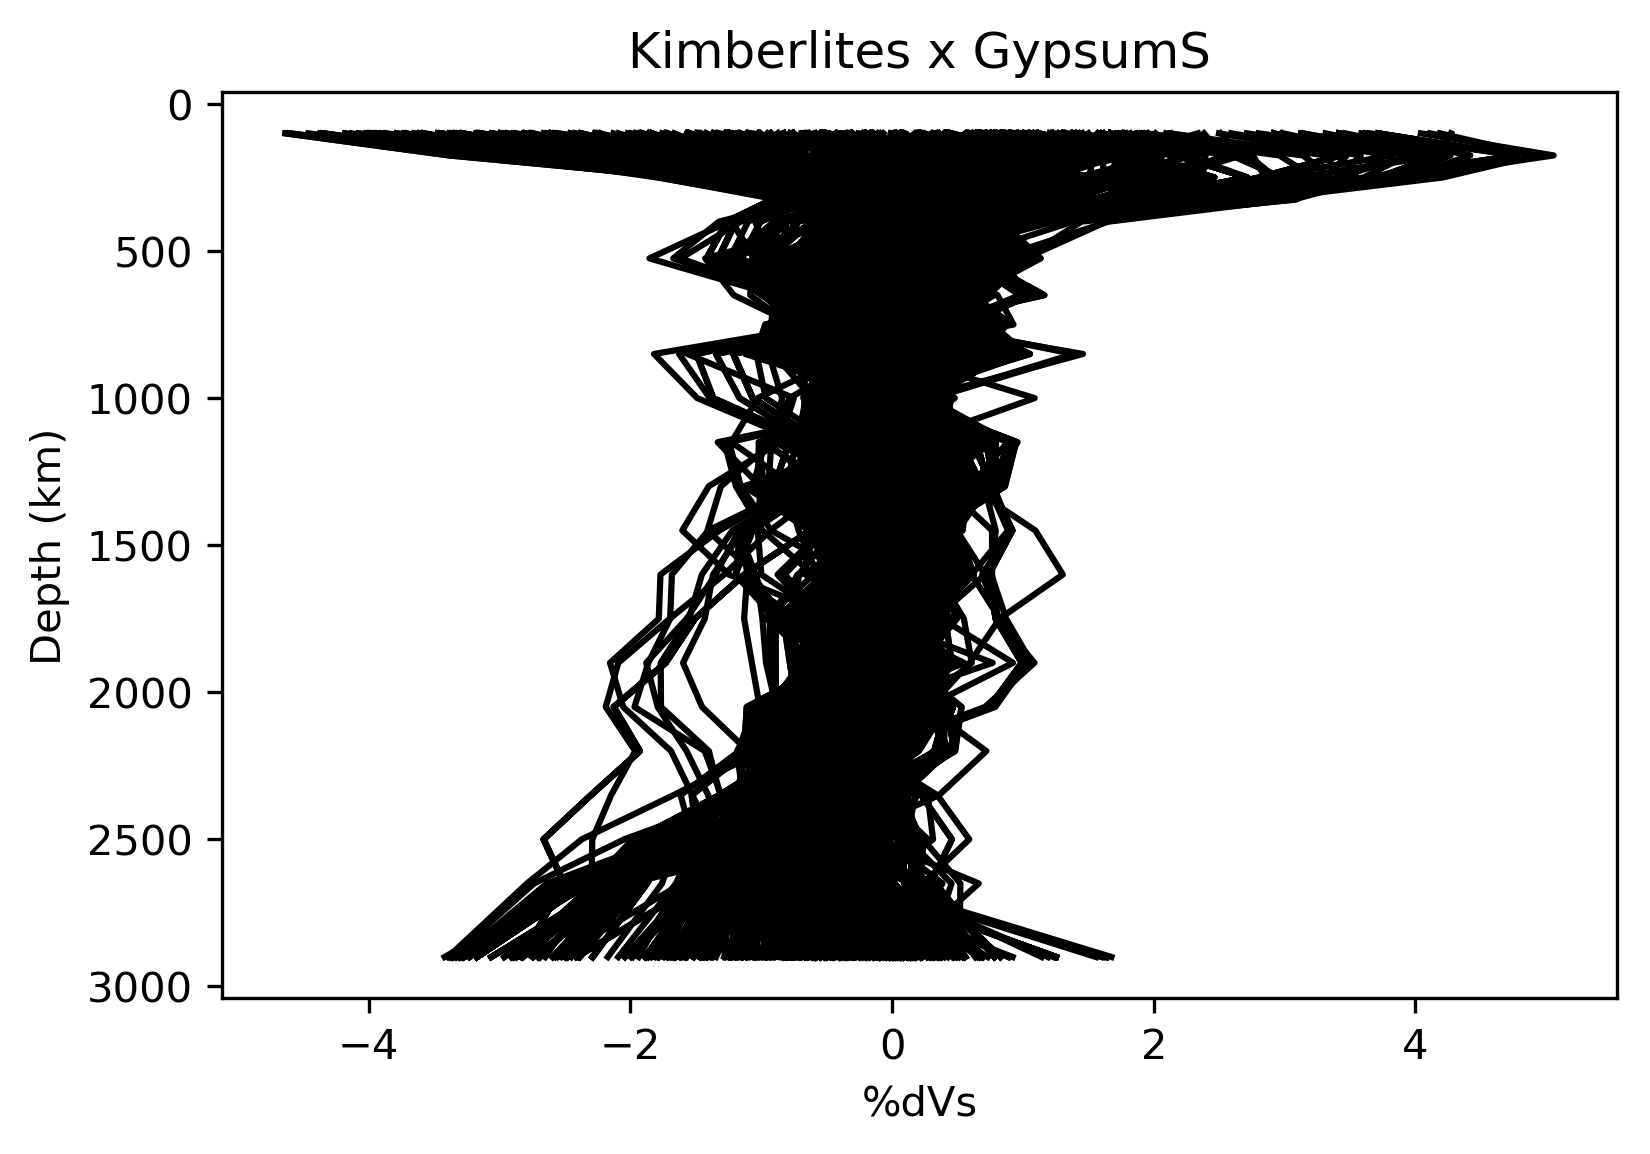

In [18]:
root='/Users/omer/Downloads/Supplement/Reconstructions/M21/'
here= '/Users/omer/Documents/Programming/PyGplates/'
# rotation_file1 = root + '1000-410_rotations-NNR.rot'
# rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
# rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file = root + '1000_0_rotfile_Merdith_et_al.rot'

rotation_model = pygplates.RotationModel(rotation_file)

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/GypsumS/Tomography'



f=open('/Users/omer/Documents/Data_Tomography_Geology/GypsumS_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points_gypsum=[]
filenames = []
vs_at_p_all_depths_gypsum=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths_gypsum=[]
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/GypsumS_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_gypsum.append(vs_at_p_d)
        
    plt.plot(vs_at_p_all_depths_gypsum,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_gypsum.append(vs_at_p_all_depths_gypsum)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
plt.title('Kimberlites x GypsumS')    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [19]:
# len(DEPTHLIST),np.asarray(vs_at_p_all_depths_all_points).shape

In [20]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/GypsumS/KimberliteField_below_GypsumS_Reconstructed_200Ma_0Ma_Paleomag.npy",
        np.asarray(vs_at_p_all_depths_all_points_gypsum,dtype="float64"))

In [9]:
Kimberlites_Below_GypsumS=np.load("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/GypsumS/KimberliteField_below_GypsumS_Reconstructed_200Ma_0Ma_Paleomag.npy")

In [10]:
Kimberlites_Below_GypsumS.shape

(679, 22, 1)

In [24]:
MyDataFrameGypsumS=pd.DataFrame(Kimberlites_Below_GypsumS.reshape(679,22))



In [25]:
# MyDataFrameGypsum=pd.DataFrame(vs_at_p_all_depths_all_points_gypsum)
GypsumS_Mean=[]
GypsumS_STD=[]
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/GypsumS_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    GypsumS_Mean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    GypsumS_STD.append(std)
    

# s40rts analysis

2  kimberlites at  198.0
2  kimberlites at  196.0
2  kimberlites at  194.0
0  kimberlites at  192.0
2  kimberlites at  190.0
1  kimberlites at  188.0
1  kimberlites at  186.0
2  kimberlites at  184.0
4  kimberlites at  182.0
4  kimberlites at  180.0
2  kimberlites at  178.0
6  kimberlites at  176.0
4  kimberlites at  174.0
5  kimberlites at  172.0
8  kimberlites at  170.0
3  kimberlites at  168.0
0  kimberlites at  166.0
4  kimberlites at  164.0
2  kimberlites at  162.0
5  kimberlites at  160.0
6  kimberlites at  158.0
8  kimberlites at  156.0
8  kimberlites at  154.0
7  kimberlites at  152.0
9  kimberlites at  150.0
7  kimberlites at  148.0
15  kimberlites at  146.0
11  kimberlites at  144.0
6  kimberlites at  142.0
9  kimberlites at  140.0
13  kimberlites at  138.0
5  kimberlites at  136.0
14  kimberlites at  134.0
16  kimberlites at  132.0
7  kimberlites at  130.0
11  kimberlites at  128.0
10  kimberlites at  126.0
13  kimberlites at  124.0
7  kimberlites at  122.0
12  kimberlites a

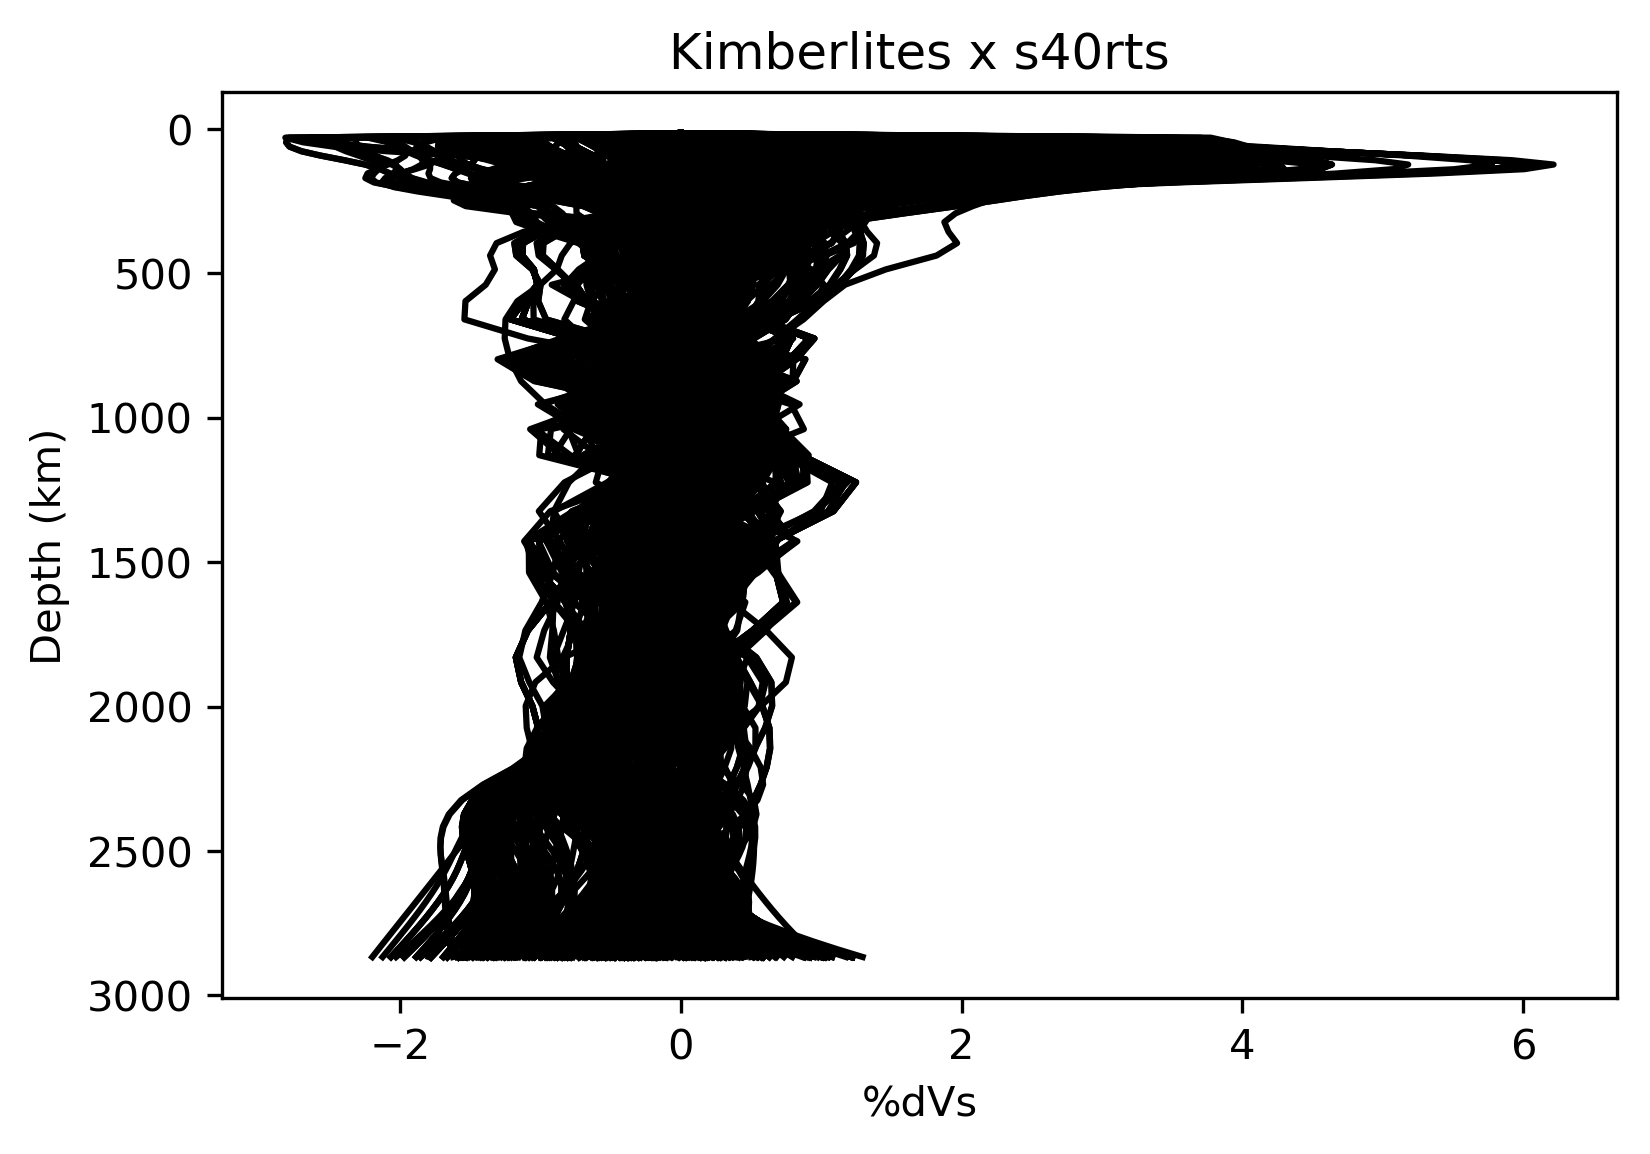

In [26]:
root='/Users/omer/Downloads/Supplement/Reconstructions/M21/'
here= '/Users/omer/Documents/Programming/PyGplates/'
# rotation_file1 = root + '1000-410_rotations-NNR.rot'
# rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
# rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file = root + '1000_0_rotfile_Merdith_et_al.rot'

rotation_model = pygplates.RotationModel(rotation_file)


grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/s40rts/Tomography/'



f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points_s40rts=[]
filenames = []
vs_at_p_all_depths_s40rts=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths_s40rts=[]
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/s40rts_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_s40rts.append(vs_at_p_d)
        
    plt.plot(vs_at_p_all_depths_s40rts,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_s40rts.append(vs_at_p_all_depths_s40rts)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
plt.title('Kimberlites x s40rts')    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [27]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/s40rts/KimberliteField_below_s40rts_Reconstructed_200Ma_0Ma.npy",
        np.asarray(vs_at_p_all_depths_all_points_s40rts, dtype="float64"))

In [28]:
Kimberlites_Below_s40rts=np.load("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/s40rts/KimberliteField_below_s40rts_Reconstructed_320Ma_0Ma.npy")

In [29]:
np.asarray(Kimberlites_Below_s40rts).shape

(762, 65, 1)

In [30]:
MyDataFrame_s40rts=pd.DataFrame(Kimberlites_Below_s40rts.reshape(762,65))

In [31]:
# MyDataFrame_s40rts=pd.DataFrame(vs_at_p_all_depths_all_points_s40rts)
s40rts_Mean=[]
s40rts_STD=[]
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/s40rts/Tomography/'



f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())



for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/s40rts_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    s40rts_Mean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    s40rts_STD.append(std)
    

In [32]:
s40rts_Mean

[nan,
 -7.1774980723e-07,
 -0.000101378748875,
 -1.29006637016e-06,
 0.000112010797895,
 0.000273631377087,
 0.000461905460646,
 0.000653180158826,
 0.000772692894849,
 0.000785980452875,
 0.000700744553705,
 0.000553089316179,
 0.000407559594956,
 0.000287085364756,
 0.000211569074753,
 0.000157221699899,
 0.000118574764976,
 6.43502534812e-05,
 -1.42813956561e-05,
 -0.000103970124502,
 -0.000171041209116,
 -0.000200551066551,
 -0.000192905376933,
 -0.000166489188149,
 -0.000154877212357,
 -0.000143435587029,
 -9.47087137754e-05,
 -6.62934622045e-05,
 -8.68031741513e-05,
 -6.760110125e-05,
 5.79736127356e-06,
 7.67903866091e-05,
 9.18101075934e-05,
 4.72780711345e-05,
 1.43650832696e-05,
 1.35102755113e-05,
 2.83248907037e-05,
 6.25407528538e-05,
 0.00011349533515,
 0.000162529505082,
 0.00019641794511,
 0.000215833570219,
 0.000221728200752,
 0.000218009547279,
 0.000210066081678,
 0.000201737795386,
 0.000195550964829,
 0.000192414835227,
 0.000191999627797,
 0.000193912199219,
 0.0

# SMEAN

2  kimberlites at  198.0
2  kimberlites at  196.0
2  kimberlites at  194.0
0  kimberlites at  192.0
2  kimberlites at  190.0
1  kimberlites at  188.0
1  kimberlites at  186.0
2  kimberlites at  184.0
4  kimberlites at  182.0
4  kimberlites at  180.0
2  kimberlites at  178.0
6  kimberlites at  176.0
4  kimberlites at  174.0
5  kimberlites at  172.0
8  kimberlites at  170.0
3  kimberlites at  168.0
0  kimberlites at  166.0
4  kimberlites at  164.0
2  kimberlites at  162.0
5  kimberlites at  160.0
6  kimberlites at  158.0
8  kimberlites at  156.0
8  kimberlites at  154.0
7  kimberlites at  152.0
9  kimberlites at  150.0
7  kimberlites at  148.0
15  kimberlites at  146.0
11  kimberlites at  144.0
6  kimberlites at  142.0
9  kimberlites at  140.0
13  kimberlites at  138.0
5  kimberlites at  136.0
14  kimberlites at  134.0
16  kimberlites at  132.0
7  kimberlites at  130.0
11  kimberlites at  128.0
10  kimberlites at  126.0
13  kimberlites at  124.0
7  kimberlites at  122.0
12  kimberlites a

IndexError: list index out of range

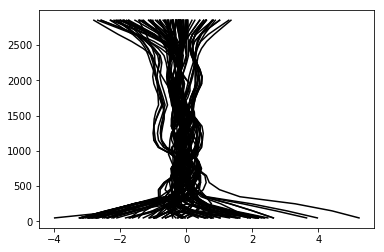

In [33]:
root='/Users/omer/Downloads/Supplement/Reconstructions/M21/'
here= '/Users/omer/Documents/Programming/PyGplates/'
# rotation_file1 = root + '1000-410_rotations-NNR.rot'
# rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
# rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file = root + '1000_0_rotfile_Merdith_et_al.rot'

rotation_model = pygplates.RotationModel(rotation_file)

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean'



f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean/smean_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points_smean=[]
filenames = []
vs_at_p_all_depths_smean=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths_smean=[]
    sayindex=1
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/dvs.%d.grd" %(grid_dir, int(sayindex))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_smean.append(vs_at_p_d)
        sayindex=sayindex+1
        
    plt.plot(vs_at_p_all_depths_smean,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_smean.append(vs_at_p_all_depths_smean)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
plt.title('Kimberlites x smean')    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [34]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean/KimberliteField_below_smean_Reconstructed_200Ma_0Ma_Paleomag.npy",
        np.asarray(vs_at_p_all_depths_all_points_smean,dtype="float64"))

In [35]:
Kimberlites_Below_smean=np.load("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean/KimberliteField_below_smean_Reconstructed_200Ma_0Ma_Paleomag.npy")

In [38]:
# SEMUCB-WM1
Kimberlites_Below_smean.shape

(101, 29, 1)

In [39]:
Kimberlites_Below_smean=Kimberlites_Below_smean.reshape(101,29)

# smean2

2  kimberlites at  198.0
2  kimberlites at  196.0
2  kimberlites at  194.0
0  kimberlites at  192.0
2  kimberlites at  190.0
1  kimberlites at  188.0
1  kimberlites at  186.0
2  kimberlites at  184.0
4  kimberlites at  182.0
4  kimberlites at  180.0
2  kimberlites at  178.0
6  kimberlites at  176.0
4  kimberlites at  174.0
5  kimberlites at  172.0
8  kimberlites at  170.0
3  kimberlites at  168.0
0  kimberlites at  166.0
4  kimberlites at  164.0
2  kimberlites at  162.0
5  kimberlites at  160.0
6  kimberlites at  158.0
8  kimberlites at  156.0
8  kimberlites at  154.0
7  kimberlites at  152.0
9  kimberlites at  150.0
7  kimberlites at  148.0
15  kimberlites at  146.0
11  kimberlites at  144.0
6  kimberlites at  142.0
9  kimberlites at  140.0
13  kimberlites at  138.0
5  kimberlites at  136.0
14  kimberlites at  134.0
16  kimberlites at  132.0
7  kimberlites at  130.0
11  kimberlites at  128.0
10  kimberlites at  126.0
13  kimberlites at  124.0
7  kimberlites at  122.0
12  kimberlites a

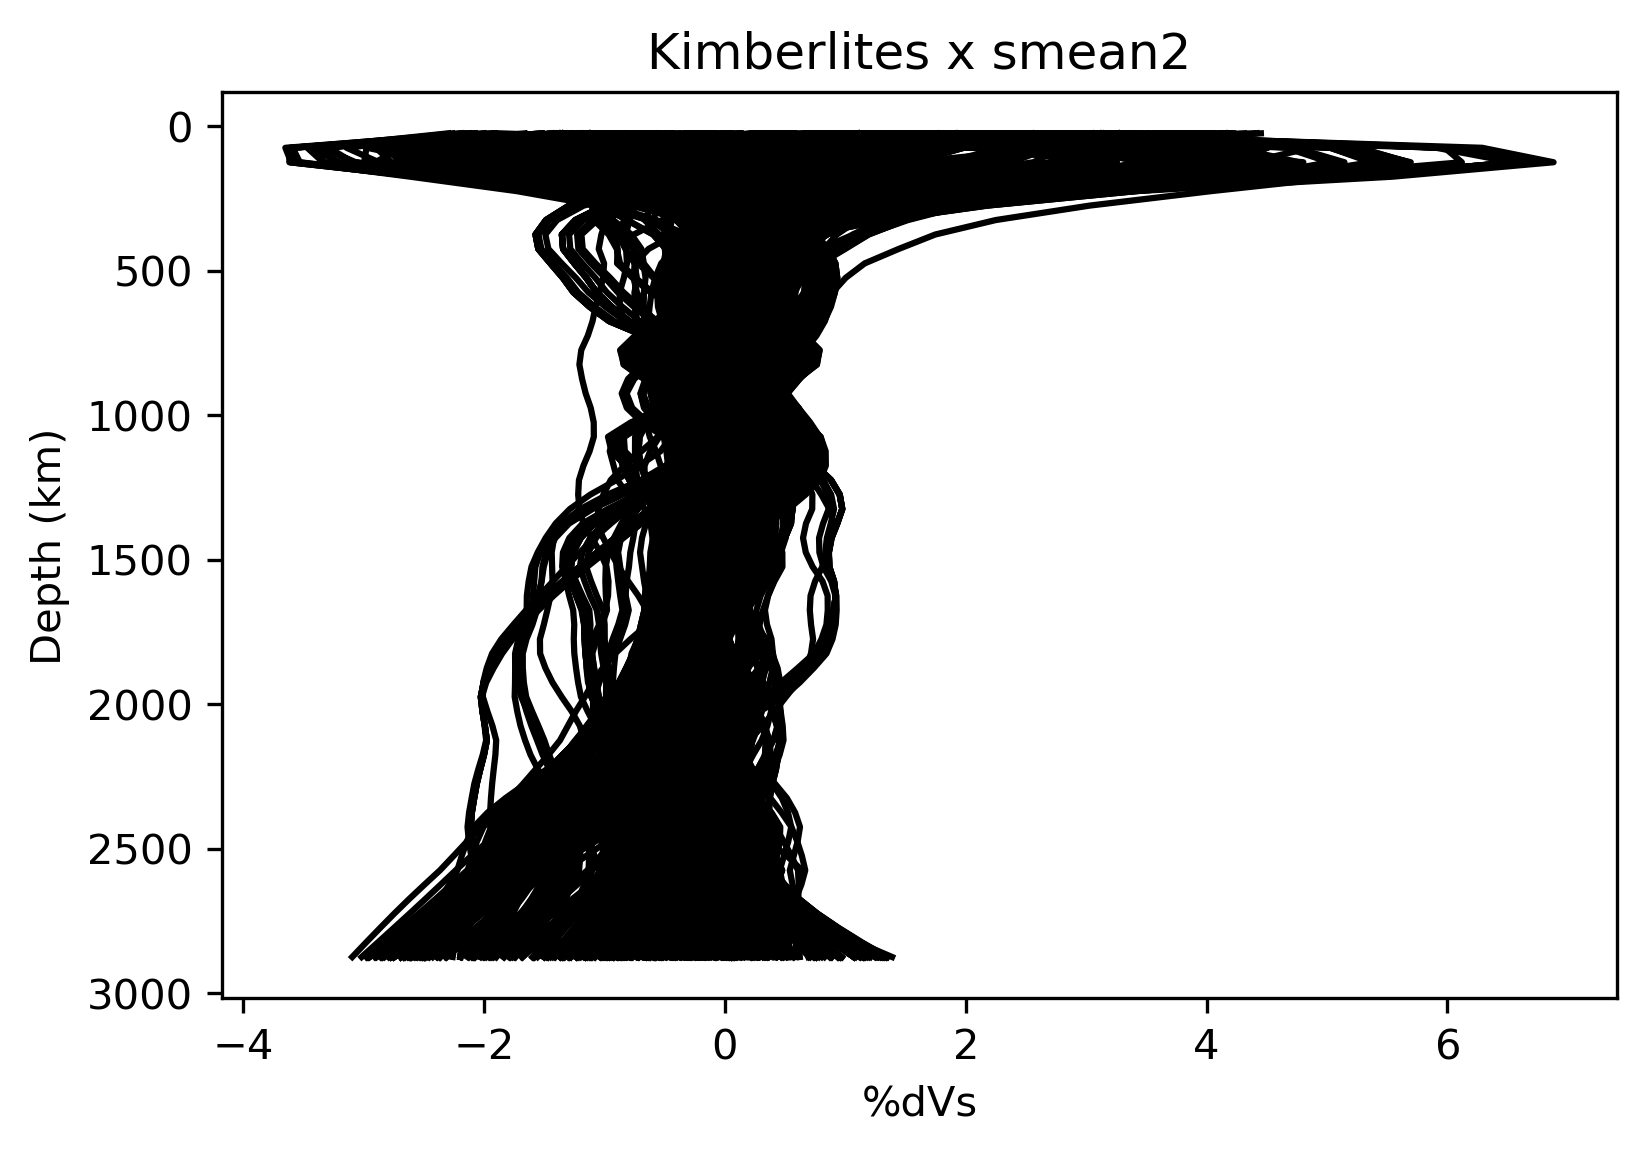

In [43]:
root='/Users/omer/Downloads/Supplement/Reconstructions/M21/'
here= '/Users/omer/Documents/Programming/PyGplates/'
# rotation_file1 = root + '1000-410_rotations-NNR.rot'
# rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
# rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file = root + '1000_0_rotfile_Merdith_et_al.rot'

rotation_model = pygplates.RotationModel(rotation_file)


grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2'



f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2/smean2_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points_smean2=[]
filenames = []
vs_at_p_all_depths_smean2=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths_smean2=[]
    sayindex=1
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/dvs.%d.grd" %(grid_dir, int(sayindex))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_smean2.append(vs_at_p_d)
        sayindex=sayindex+1
        
    plt.plot(vs_at_p_all_depths_smean2,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_smean2.append(vs_at_p_all_depths_smean2)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
plt.title('Kimberlites x smean2')    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [46]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2/KimberliteField_below_smean2_Reconstructed_200Ma_0MaPaleoMag.npy",
        np.asarray(vs_at_p_all_depths_all_points_smean2,dtype="float64"))

In [49]:
Kimberlites_Below_smean2=np.load(
    "/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2/KimberliteField_below_smean2_Reconstructed_200Ma_0MaPaleoMag.npy")


2  kimberlites at  198.0
2  kimberlites at  196.0
2  kimberlites at  194.0
0  kimberlites at  192.0
2  kimberlites at  190.0
1  kimberlites at  188.0
1  kimberlites at  186.0
2  kimberlites at  184.0
4  kimberlites at  182.0
4  kimberlites at  180.0
2  kimberlites at  178.0
6  kimberlites at  176.0
4  kimberlites at  174.0
5  kimberlites at  172.0
8  kimberlites at  170.0
3  kimberlites at  168.0
0  kimberlites at  166.0
4  kimberlites at  164.0
2  kimberlites at  162.0
5  kimberlites at  160.0
6  kimberlites at  158.0
8  kimberlites at  156.0
8  kimberlites at  154.0
7  kimberlites at  152.0
9  kimberlites at  150.0
7  kimberlites at  148.0
15  kimberlites at  146.0
11  kimberlites at  144.0
6  kimberlites at  142.0
9  kimberlites at  140.0
13  kimberlites at  138.0
5  kimberlites at  136.0
14  kimberlites at  134.0
16  kimberlites at  132.0
7  kimberlites at  130.0
11  kimberlites at  128.0
10  kimberlites at  126.0
13  kimberlites at  124.0
7  kimberlites at  122.0
12  kimberlites a

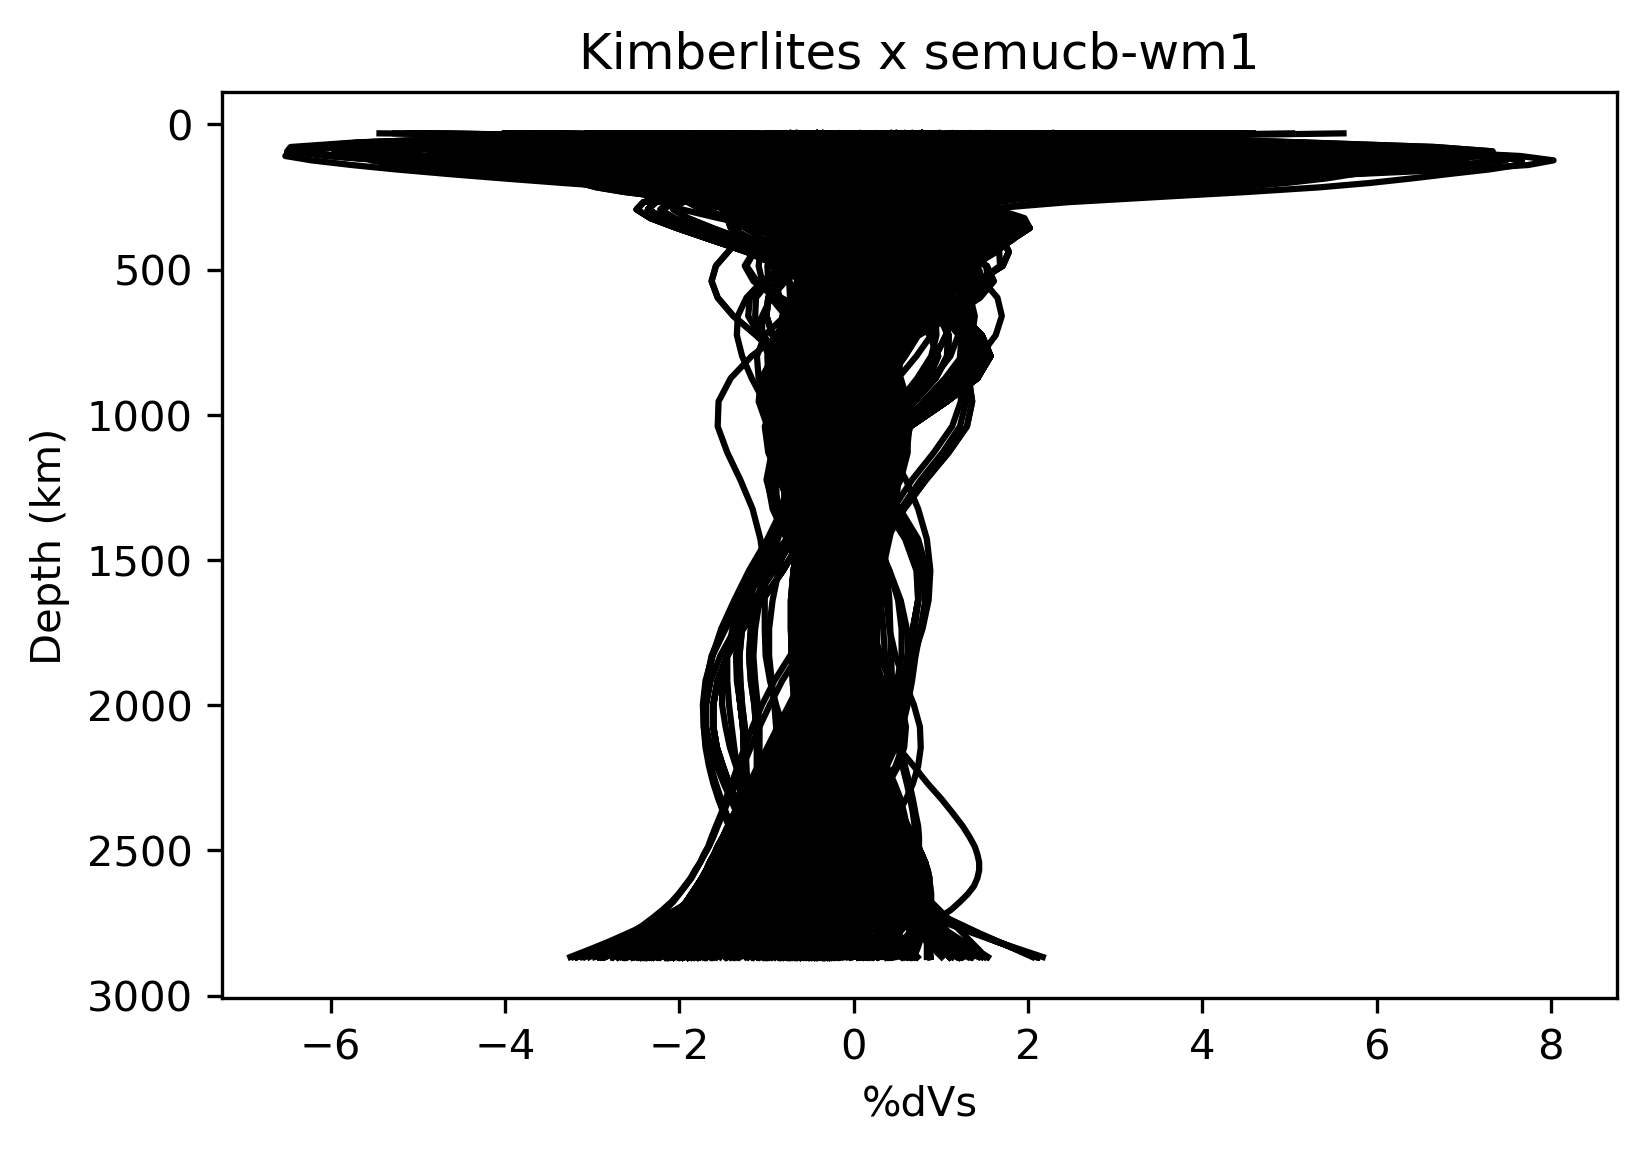

In [50]:
root='/Users/omer/Downloads/Supplement/Reconstructions/M21/'
here= '/Users/omer/Documents/Programming/PyGplates/'
# rotation_file1 = root + '1000-410_rotations-NNR.rot'
# rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
# rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file = root + '1000_0_rotfile_Merdith_et_al.rot'

rotation_model = pygplates.RotationModel(rotation_file)

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/SEMUCB-WM1/Tomography'



f=open('/Users/omer/Documents/Data_Tomography_Geology/semucb-wm1_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points_semucb_wm1=[]
filenames = []
vs_at_p_all_depths_semucb_wm1=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths_semucb_wm1=[]
    sayindex=1
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/SEMUCB-WM1_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_semucb_wm1.append(vs_at_p_d)
        sayindex=sayindex+1
        
    plt.plot(vs_at_p_all_depths_semucb_wm1,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_semucb_wm1.append(vs_at_p_all_depths_semucb_wm1)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
plt.title('Kimberlites x semucb-wm1')    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [51]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/SEMUCB-WM1/Tomography/KimberliteField_below_semucb_wm1_Reconstructed_200Ma_0Ma_Paleomag.npy",
        np.asarray(vs_at_p_all_depths_all_points_semucb_wm1,dtype="float64"))

In [55]:
Kimberlites_Below_semucb_wm1PaleoMag=np.load("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/SEMUCB-WM1/Tomography/KimberliteField_below_semucb_wm1_Reconstructed_200Ma_0Ma_Paleomag.npy")

In [58]:
Kimberlites_Below_semucb_wm1PaleoMag=Kimberlites_Below_semucb_wm1PaleoMag.reshape(679,65)

# HMSL.S

2  kimberlites at  198.0
2  kimberlites at  196.0
2  kimberlites at  194.0
0  kimberlites at  192.0
2  kimberlites at  190.0
1  kimberlites at  188.0
1  kimberlites at  186.0
2  kimberlites at  184.0
4  kimberlites at  182.0
4  kimberlites at  180.0
2  kimberlites at  178.0
6  kimberlites at  176.0
4  kimberlites at  174.0
5  kimberlites at  172.0
8  kimberlites at  170.0
3  kimberlites at  168.0
0  kimberlites at  166.0
4  kimberlites at  164.0
2  kimberlites at  162.0
5  kimberlites at  160.0
6  kimberlites at  158.0
8  kimberlites at  156.0
8  kimberlites at  154.0
7  kimberlites at  152.0
9  kimberlites at  150.0
7  kimberlites at  148.0
15  kimberlites at  146.0
11  kimberlites at  144.0
6  kimberlites at  142.0
9  kimberlites at  140.0
13  kimberlites at  138.0
5  kimberlites at  136.0
14  kimberlites at  134.0
16  kimberlites at  132.0
7  kimberlites at  130.0
11  kimberlites at  128.0
10  kimberlites at  126.0
13  kimberlites at  124.0
7  kimberlites at  122.0
12  kimberlites a

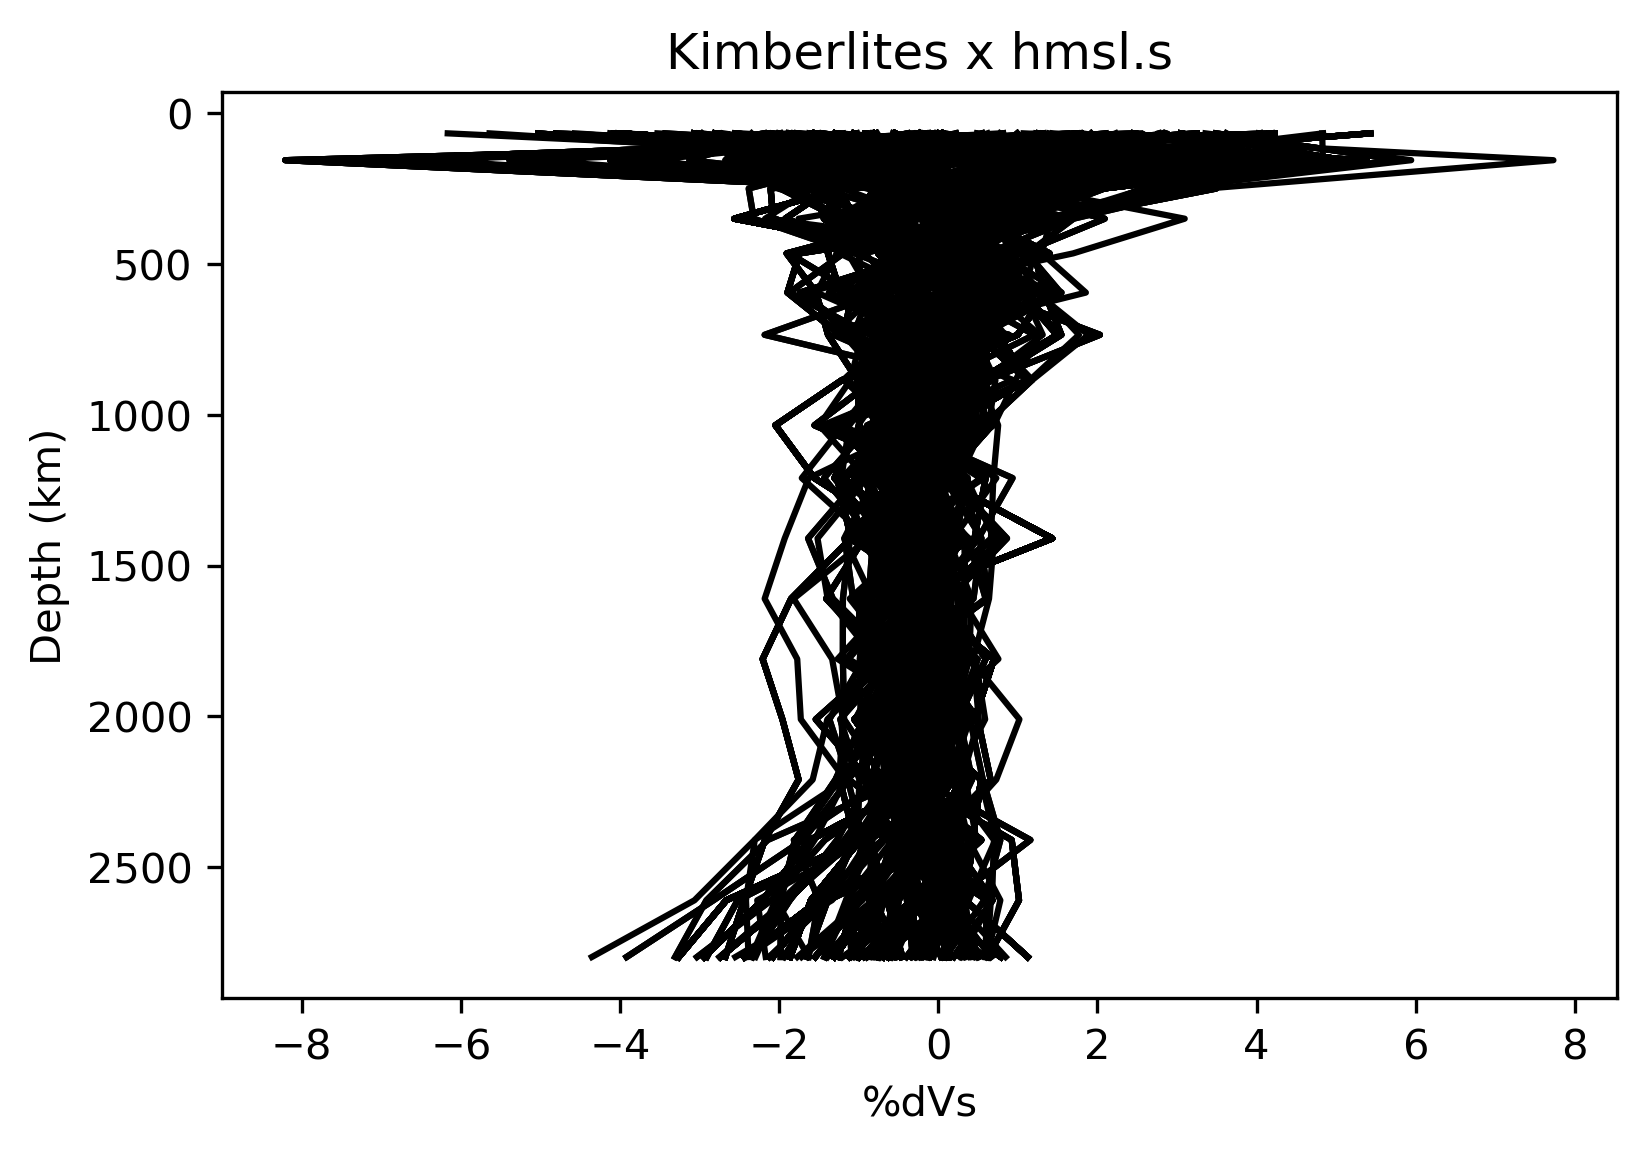

In [59]:
root='/Users/omer/Downloads/Supplement/Reconstructions/M21/'
here= '/Users/omer/Documents/Programming/PyGplates/'
# rotation_file1 = root + '1000-410_rotations-NNR.rot'
# rotation_file2 = root + 'Global_EB_410-250Ma_GK07_2017-NNR.rot'
# rotation_file3 = root + 'Global_EB_250-0Ma_GK07_2017-NNR.rot'
rotation_file = root + '1000_0_rotfile_Merdith_et_al.rot'

rotation_model = pygplates.RotationModel(rotation_file)

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/HMSL.S/Tomography'



f=open('/Users/omer/Documents/Data_Tomography_Geology/HMSL_S_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

step=-2

agemin=-2

agemina=agemin

agemax=200

agemaxa=agemax

anchor_plate_id=0

AllLats=[]
AllLons=[]
vs_at_p_all_depths_all_points_hmsl_s=[]
filenames = []
vs_at_p_all_depths_hmsl_s=[]

for age1 in xrange(agemax,agemin,step):
    
    age2 = age1+step # 1st iteration:330 Ma - 310 Ma
    age1f=float(age1)
    age2f=float(age2)
    ageofVtk=age1+step
    ageofVtkf=float(ageofVtk)
    
    
    # Start with an empty list of features that appear between age1 and age2 Ma.
#     features_to_modify = []
    
#     for feature in point_features:
#         name = feature.get_name()
#         begin_time, end_time = feature.get_valid_time()
     
#         if begin_time < age1f and begin_time >= age2f:
#             feature.set_valid_time(age1f, age2f)
#             features_to_modify.append(feature)
    
    
    Lons=[]
    Lats=[]
    numKimb=0
    for feature in point_features:
        
        point = feature.get_geometry()
        PlateID = feature.get_reconstruction_plate_id()
        BirthTime=feature.get_valid_time()[0]
        
        if BirthTime < age1f and BirthTime >= age2f:
            PlateRotation = rotation_model.get_rotation(ageofVtk, PlateID, anchor_plate_id)
            reconstructed_point = PlateRotation * point
            reconstructed_point_degrees = reconstructed_point.to_lat_lon_point()
            Lats.append(reconstructed_point_degrees.get_latitude())
            Lons.append(reconstructed_point_degrees.get_longitude())
            numKimb=numKimb+1
        
#             feature.set_valid_time(age1f, age2f)
            
#             features_to_modify.append(feature)
            
        
#         a,b= PlateRotation.get_euler_pole_and_angle()
#         print a,b," : are Euler Pole and Angle, resp."
#         reconstructed_point = PlateRotation * point.get_geometry()
#         reconstructed_point = PlateRotation * point
#         print point," is recons. to: ",reconstructed_point, " with PlateID", PlateID

    
    print numKimb, " kimberlites at ", ageofVtkf  

        
    AllLats.extend(Lats)
    AllLons.extend(Lons)
    


index=0    
for latitude in AllLats:
    vs_at_p_all_depths_hmsl_s=[]
    sayindex=1
    for depth in DEPTHLIST:
#     print depth
        tomo_pile_input_file = "%s/HMSL.S_%d.nc" %(grid_dir, int(depth))  
           
        
#         print latitude
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, AllLons[index], latitude)
        
        vs_at_p_all_depths_hmsl_s.append(vs_at_p_d)
        sayindex=sayindex+1
        
    plt.plot(vs_at_p_all_depths_hmsl_s,np.asarray(DEPTHLIST,dtype="float64"),c='k')

    
    vs_at_p_all_depths_all_points_hmsl_s.append(vs_at_p_all_depths_hmsl_s)

    
#     Vs_mean_global_gypsum=np.append(Vs_mean_global,mean)
    index=index+1

    

    
#     vs_at_p_all_depths_all_points=[]
#     vs_at_p_all_depths=[]
    
plt.title('Kimberlites x hmsl.s')    
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300    
plt.show()
    
        
# Elle=vs_at_p_all_depths_all_points.reshape(3,763)        
    
#     for p in features_to_modify:
    
#     #the code below uses pygplates to find point latitudes and longitudes
#     point = p.get_geometry()
#     ID=p.get_reconstruction_plate_id()
#     point_degrees = point.to_lat_lon_point()
#     point_lon = point_degrees.get_longitude()
#     point_lat = point_degrees.get_latitude()
#     eruptionTime= ageofVtkf
    
#     # reconstruct the point
#     #the code below finds the value of the tomography model at a given point and depth    
#     vs_at_p_all_depths =[]
#     for depth in DEPTHLIST:
#         tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
#         vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
#         vs_at_p_all_depths.append(vs_at_p_d)
        
#     vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)
    
    
    ##the list vs_at_p_all_depths_all_points should contain all 1-D profiles of Vs over depth
#     vs_at_p = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
    
#     print(vs_at_p)

In [60]:
np.save("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/HMSL.S/Tomography/KimberliteField_below_HMSL_S_Reconstructed_200Ma_0Ma_Paleomag.npy",
        np.asarray(vs_at_p_all_depths_all_points_hmsl_s,dtype="float64"))

In [62]:
Kimberlites_Below_hmsl_sPalemomag=np.load("/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/HMSL.S/Tomography/KimberliteField_below_HMSL_S_Reconstructed_200Ma_0Ma_Paleomag.npy")

In [65]:
Kimberlites_Below_hmsl_sPalemomag=Kimberlites_Below_hmsl_sPalemomag.reshape(679,18)

In [ ]:
f=open('/Users/omer/Documents/Data_Tomography_Geology/savani_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())
plt.close()
# plt.plot(MyDataFrame.mean(),np.asarray(DEPTHLIST,dtype="float64"), label="Kimberlites 0-320 Ma (Savani)")
# plt.errorbar(MyDataFrame.mean(),np.asarray(DEPTHLIST,dtype="float64"), 
#              xerr=MyDataFrame.std(),label="Kimberlites with std 0-320 Ma (Savani)")


plt.plot(MyDataFrame.mean(),np.asarray(DEPTHLIST,dtype="float64"),label="Kimberlites 0-320 Ma (Savani)",c="orange")


plt.plot(SavaniMean,np.asarray(DEPTHLIST,dtype="float64"),"--",label="Savani Global Average",c="orange")

f=open('/Users/omer/Documents/Data_Tomography_Geology/GypsumS_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

    
    
# plt.errorbar(MyDataFrameGypsum.mean(),np.asarray(DEPTHLIST,dtype="float64"), 
#              xerr=MyDataFrameGypsum.std(),label="Kimberlites with std 0-320 Ma (GypsumS)")


plt.plot(MyDataFrameGypsum.mean(),np.asarray(DEPTHLIST,dtype="float64"),label="Kimberlites 0-320 Ma (GypsumS)",c="k")

plt.plot(GypsumS_Mean,np.asarray(DEPTHLIST,dtype="float64"),"--",label="GypsumS Global Average",c="k")



f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())



plt.plot(MyDataFrame_s40rts.mean(),np.asarray(DEPTHLIST,dtype="float64"),label="Kimberlites 0-320 Ma (s40rts)",c="blue")

plt.plot(s40rts_Mean,np.asarray(DEPTHLIST,dtype="float64"),"--",label="s40rts Global Average",c="blue")

plt.plot()
plt.plot()
plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300
plt.ylim(3000,500)
plt.xlim(-1.,1.)
plt.legend()
plt.grid()
plt.show()
    

In [ ]:
8+2+5+ 13+ 30  + 14 +19 +37 + 52 +103 + 95 +120  +166 + 83 + 11 + 3 + 1 

In [ ]:
np.asarray(vs_at_p_all_depths_all_points).shape

In [ ]:
vs_at_p_all_depths_all_points

In [ ]:
New=np.asarray(vs_at_p_all_depths_all_points,dtype="float64").reshape(762,len(DEPTHLIST))

In [ ]:
# Newdf.mean()
New[0].shape

In [ ]:
Newdf=pd.DataFrame(New)

In [ ]:
# vs_at_p_all_depths_all_points

dd=np.asarray(vs_at_p_all_depths_all_points,dtype="float64")
plt.close()
for index in range(0,762,1): #12971
    
    plt.plot(New[index],np.asarray(DEPTHLIST,dtype="float64"),linewidth=0.3, alpha=0.3)

plt.plot(Newdf.mean(),np.asarray(DEPTHLIST,dtype="float64"),linewidth=2,c='black')

plt.gca().invert_yaxis()
plt.xlabel("%dVs")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300
# plt.xlim(-4.0,4.0)
# plt.ylim(2900,500)
# plt.title("Plate ID: "+str(IDs[0]))
plt.show()

In [ ]:
Newdf=pd.DataFrame(New)

In [ ]:
Newdf.mean()

In [ ]:
for p in point_features:
    
    #the code below uses pygplates to find point latitudes and longitudes
    point = p.get_geometry()
    ID=p.get_reconstruction_plate_id()
    point_degrees = point.to_lat_lon_point()
    point_lon = point_degrees.get_longitude()
    point_lat = point_degrees.get_latitude()
    eruptionTime= p.
    #the code below finds the value of the tomography model at a given point and depth
    if ()
    vs_at_p_all_depths =[]
    for depth in DEPTHLIST:
        tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
        vs_at_p_d = sample_using_gmt(tomo_pile_input_file, point_lon, point_lat)
        vs_at_p_all_depths.append(vs_at_p_d)
        
    vs_at_p_all_depths_all_points.append(vs_at_p_all_depths)

In [ ]:
for depth in DEPTHLIST[0:3]:
    print depth

# Compute the means

In [5]:
s40rts_Mean=[]
s40rts_STD=[]
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/s40rts/Tomography/'

f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/s40rts_%d.nc" %(grid_dir, int(depth))  

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    s40rts_Mean.append(mean)
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    s40rts_STD.append(std)
    
    
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/GypsumS/Tomography/'

f=open('/Users/omer/Documents/Data_Tomography_Geology/GypsumS_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

GypsumS_Mean=[]
GypsumS_STD=[]
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/GypsumS_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    GypsumS_Mean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    GypsumS_STD.append(std)
    
    
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/savani/Tomography/'

f=open('/Users/omer/Documents/Data_Tomography_Geology/savani_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

SavaniMean=[]
Savani_STD=[]
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/savani_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    SavaniMean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    Savani_STD.append(std)
    

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/HMSL.S/Tomography'

f=open('/Users/omer/Documents/Data_Tomography_Geology/HMSL_S_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

hmsl_s_Mean=[]
hmsl_s_STD=[]
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/HMSL.S_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    hmsl_s_Mean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    hmsl_s_STD.append(std)

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/SEMUCB-WM1/Tomography'

f=open('/Users/omer/Documents/Data_Tomography_Geology/semucb-wm1_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

semucb_wm1_Mean=[]
semucb_wm1_STD=[]
for depth in DEPTHLIST:
#     print depth
    tomo_pile_input_file = "%s/SEMUCB-WM1_%d.nc" %(grid_dir, int(depth))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    semucb_wm1_Mean.append(mean)
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    semucb_wm1_STD.append(std)   
    
grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean'

f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean/smean_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())
    
    
smean_Mean=[]
smean_STD=[]
sayindex=1
for depth in DEPTHLIST:
#     print depth
    
    tomo_pile_input_file = "%s/dvs.%d.grd" %(grid_dir, int(sayindex))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    smean_Mean.append(mean)
    
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    smean_STD.append(std)  
    sayindex=sayindex+1

grid_dir='/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2'

f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2/smean2_depths.txt','r')

DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())
        
    
smean2_Mean=[]
smean2_STD=[]
sayindex=1
for depth in DEPTHLIST:
#     print depth
    
    tomo_pile_input_file = "%s/dvs.%d.grd" %(grid_dir, int(sayindex))  
           
        

    mean=float(call_system_command(['gmt',

                         'grdinfo',

                         '-Cn',

                         '-L2',

                         '-o10',

                         '%s' % tomo_pile_input_file],

                          return_stdout=True))

    smean2_Mean.append(mean)
    
    
    std=float(call_system_command(['gmt',

                     'grdinfo',

                     '-Cn',

                     '-L2',

                     '-o11',

                     '%s' % tomo_pile_input_file],

                      return_stdout=True))

    smean2_STD.append(std)  
    sayindex=sayindex+1



In [11]:
len(hmsl_s_Mean)

18

# Plot Means

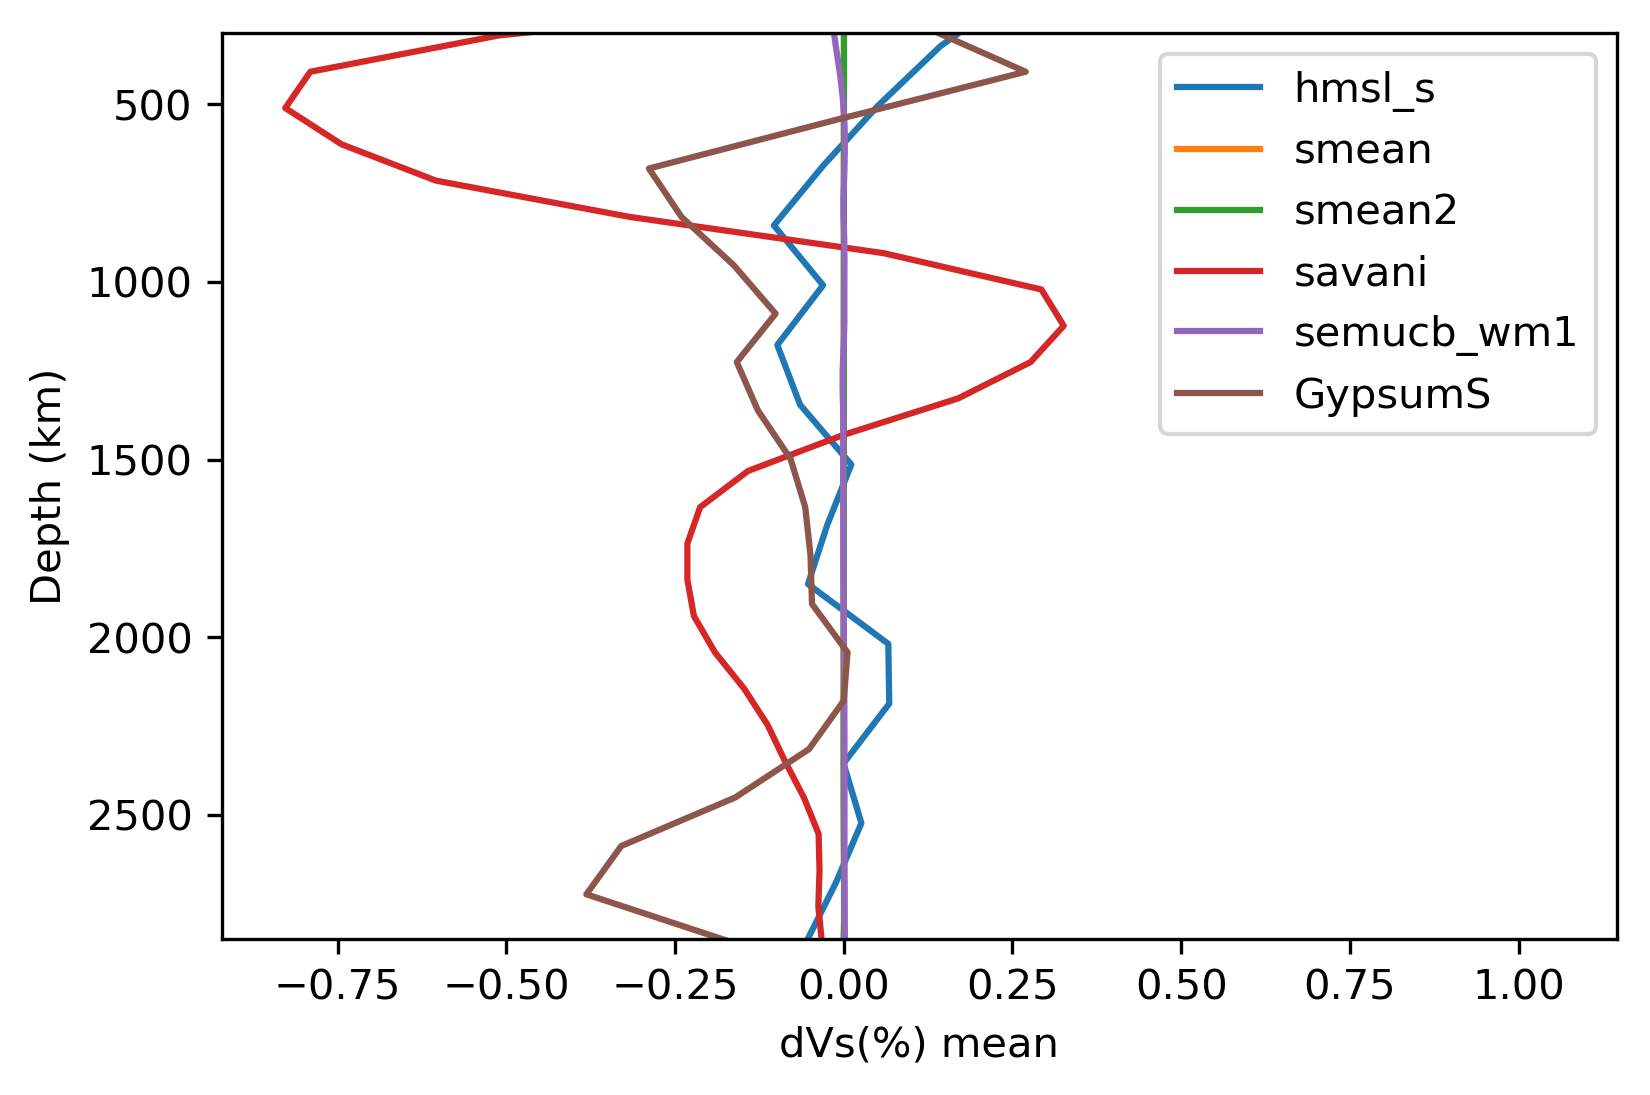

In [13]:
plt.close()


plt.plot(np.asarray(hmsl_s_Mean,dtype='float64'),np.linspace(0,2860,len(hmsl_s_Mean)),label='hmsl_s')

plt.plot(np.asarray(smean_Mean,dtype='float64'),np.linspace(0,2860,len(smean_Mean)),label='smean')

plt.plot(np.asarray(smean2_Mean,dtype='float64'),np.linspace(0,2860,len(smean2_Mean)),label='smean2')

plt.plot(np.asarray(SavaniMean,dtype='float64'),np.linspace(0,2860,len(SavaniMean)),label='savani')

plt.plot(np.asarray(semucb_wm1_Mean,dtype='float64'),np.linspace(0,2860,len(semucb_wm1_Mean)),label='semucb_wm1')

plt.plot(np.asarray(GypsumS_Mean,dtype='float64'),np.linspace(0,2860,len(GypsumS_Mean)),label='GypsumS')

plt.legend()
plt.gca().invert_yaxis()

plt.ylabel('Depth (km)')
plt.xlabel('dVs(%) mean')
plt.ylim(2850,300)
plt.gca().figure.dpi=300
plt.show()




In [ ]:
Kimb

# Tomography Models Comparison

In [3]:
Kimberlites_Below_hmsl_s=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/HMSL.S/Tomography/KimberliteField_below_HMSL_S_Reconstructed_200Ma_0Ma_Paleomag.npy")

Kimberlites_Below_semucb_wm1=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/SEMUCB-WM1/Tomography/KimberliteField_below_semucb_wm1_Reconstructed_200Ma_0Ma_Paleomag.npy")

Kimberlites_Below_smean=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/smean/KimberliteField_below_smean_Reconstructed_200Ma_0Ma_Paleomag.npy")

Kimberlites_Below_smean2=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/smean2/KimberliteField_below_smean2_Reconstructed_200Ma_0MaPaleomag.npy")

Kimberlites_Below_s40rts=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/s40rts/KimberliteField_below_s40rts_Reconstructed_200Ma_0Ma.npy")

Kimberlites_Below_GypsumS=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/GypsumS/KimberliteField_below_GypsumS_Reconstructed_200Ma_0Ma_Paleomag.npy")

Kimb_below_Savani=np.load("/Users/omer/Documents/Data_Tomography_Geology/\
Tomography_models/savani/KimberliteField_below_Savani_Reconstructed_200Ma_0Ma_Paleomag.npy")



In [7]:
Kimberlites_Below_smean2.shape,Kimberlites_Below_hmsl_s.shape

((679, 58, 1), (679, 18, 1))

In [8]:
df=pd.DataFrame(Kimberlites_Below_hmsl_s.reshape(762,11))
df.mean()

ValueError: cannot reshape array of size 12222 into shape (762,11)

# PLOT ALL

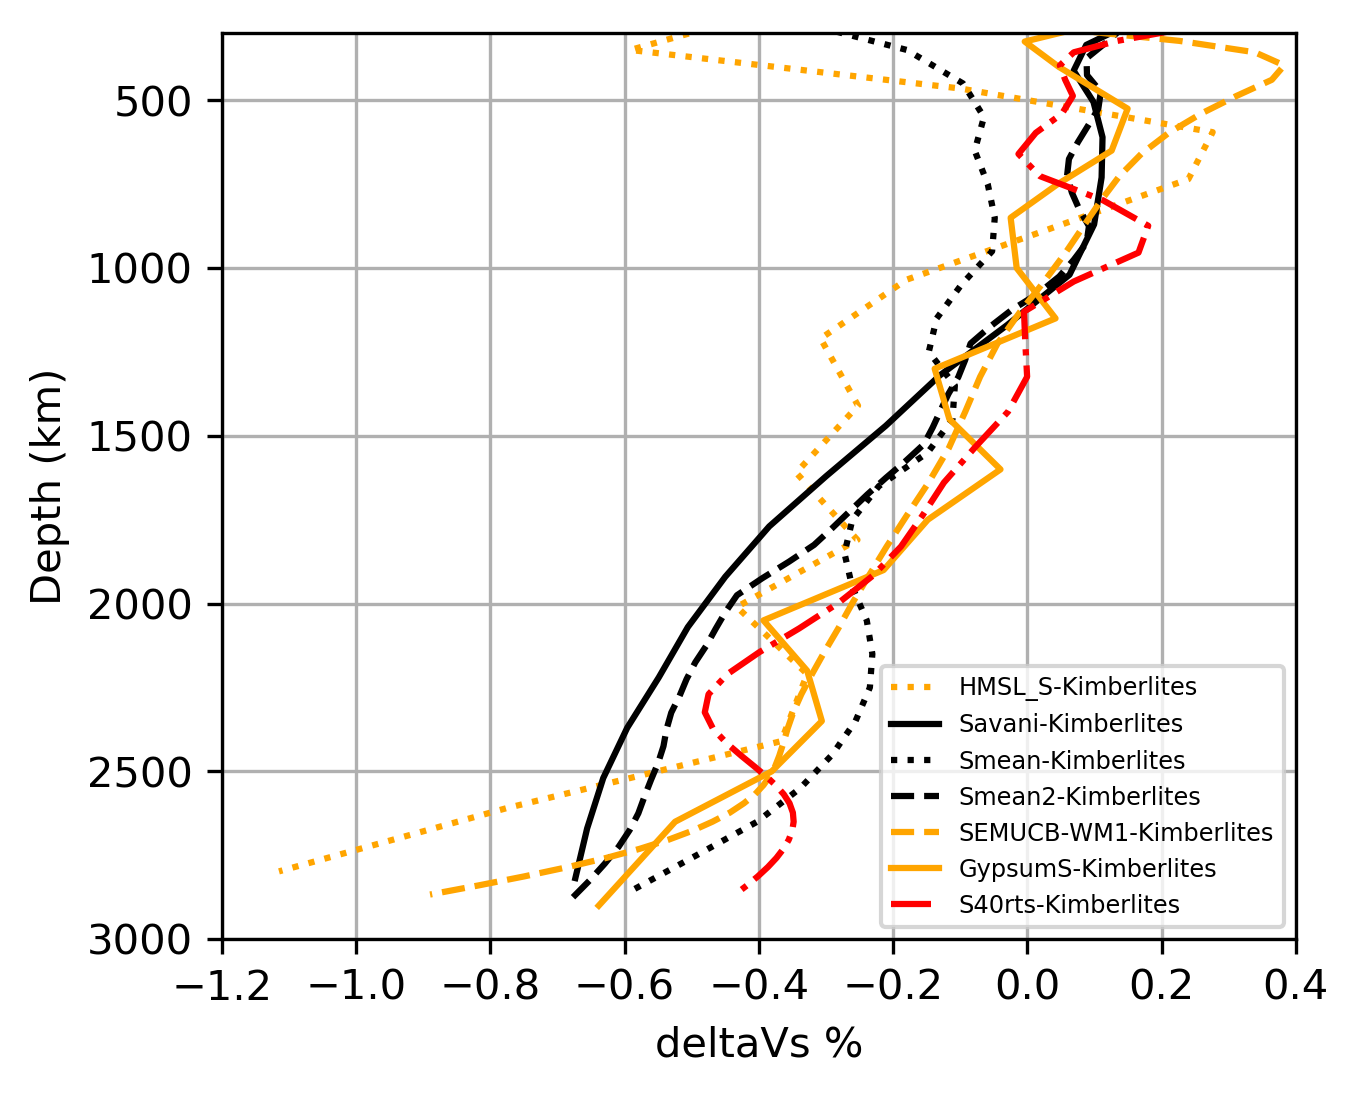

In [16]:
f=open('/Users/omer/Documents/Data_Tomography_Geology/HMSL_S_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimberlites_Below_hmsl_s.reshape(679,18))
plt.plot(df.mean()-np.asarray(hmsl_s_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='orange',label="HMSL_S-Kimberlites",linestyle=':')
# plt.plot(hmsl_s_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='k',linestyle='dashed',label="HMSL_S-global-mean")

f=open('/Users/omer/Documents/Data_Tomography_Geology/savani_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimb_below_Savani.reshape(679,29))
# plt.plot(df.mean(),np.asarray(DEPTHLIST,dtype="float64"),c='black',label="Savani-Kimberlites",linestyle='-')
# plt.plot(SavaniMean,np.asarray(DEPTHLIST,dtype="float64"),c='b',linestyle='dashed',label="Savani-global-mean")

plt.plot(df.mean()-np.asarray(SavaniMean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='black',label="Savani-Kimberlites",linestyle='-')


f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean/smean_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimberlites_Below_smean.reshape(101,29))
plt.plot(df.mean()-np.asarray(smean_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='black',label="Smean-Kimberlites",linestyle=':')
# plt.plot(smean_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='orange',linestyle='dashed',label="Smean-global-mean")


f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2/smean2_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimberlites_Below_smean2.reshape(679,58))
plt.plot(df.mean()-np.asarray(smean2_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='black',label="Smean2-Kimberlites",linestyle='--')
# plt.plot(smean2_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='purple',linestyle='dashed',label="Smean2-global-mean")



f=open('/Users/omer/Documents/Data_Tomography_Geology/semucb-wm1_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimberlites_Below_semucb_wm1.reshape(679,65))
plt.plot(df.mean()-np.asarray(semucb_wm1_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='orange',label="SEMUCB-WM1-Kimberlites", linestyle='--')
# plt.plot(semucb_wm1_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='green',linestyle='dashed',label="SEMUCB-WM1-global-mean")



f=open('/Users/omer/Documents/Data_Tomography_Geology/GypsumS_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimberlites_Below_GypsumS.reshape(679,22))
plt.plot(df.mean()-np.asarray(GypsumS_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='orange',label="GypsumS-Kimberlites", linestyle='-')
# plt.plot(GypsumS_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='cyan',linestyle='dashed',label="GypsumS-global-mean")



f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimberlites_Below_s40rts.reshape(679,65))
plt.plot(df.mean()-np.asarray(s40rts_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='red',label="S40rts-Kimberlites",linestyle='-.')
# plt.plot(s40rts_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='red',linestyle='dashed',label="S40rts-global-mean")



plt.plot()


# plt.title('Kimberlites x hmsl.s')    
plt.gca().invert_yaxis()
plt.xlabel("deltaVs %")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300   
plt.xlim(-1.2,0.4)
plt.xticks([-1.2,-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4])
plt.ylim(3000,300)
plt.legend(fontsize='xx-small')
plt.grid()
plt.gca().set_aspect(5e-4)
# plt.show()
plt.savefig('Tomography_vsDepth_Shifted_by_mean_Paleomag-23Nov2021.pdf',dpi=300)
plt.savefig('Tomography_vsDepth_Shifted_by_mean_Paleomag-23Nov2021.png',dpi=300)


    
        

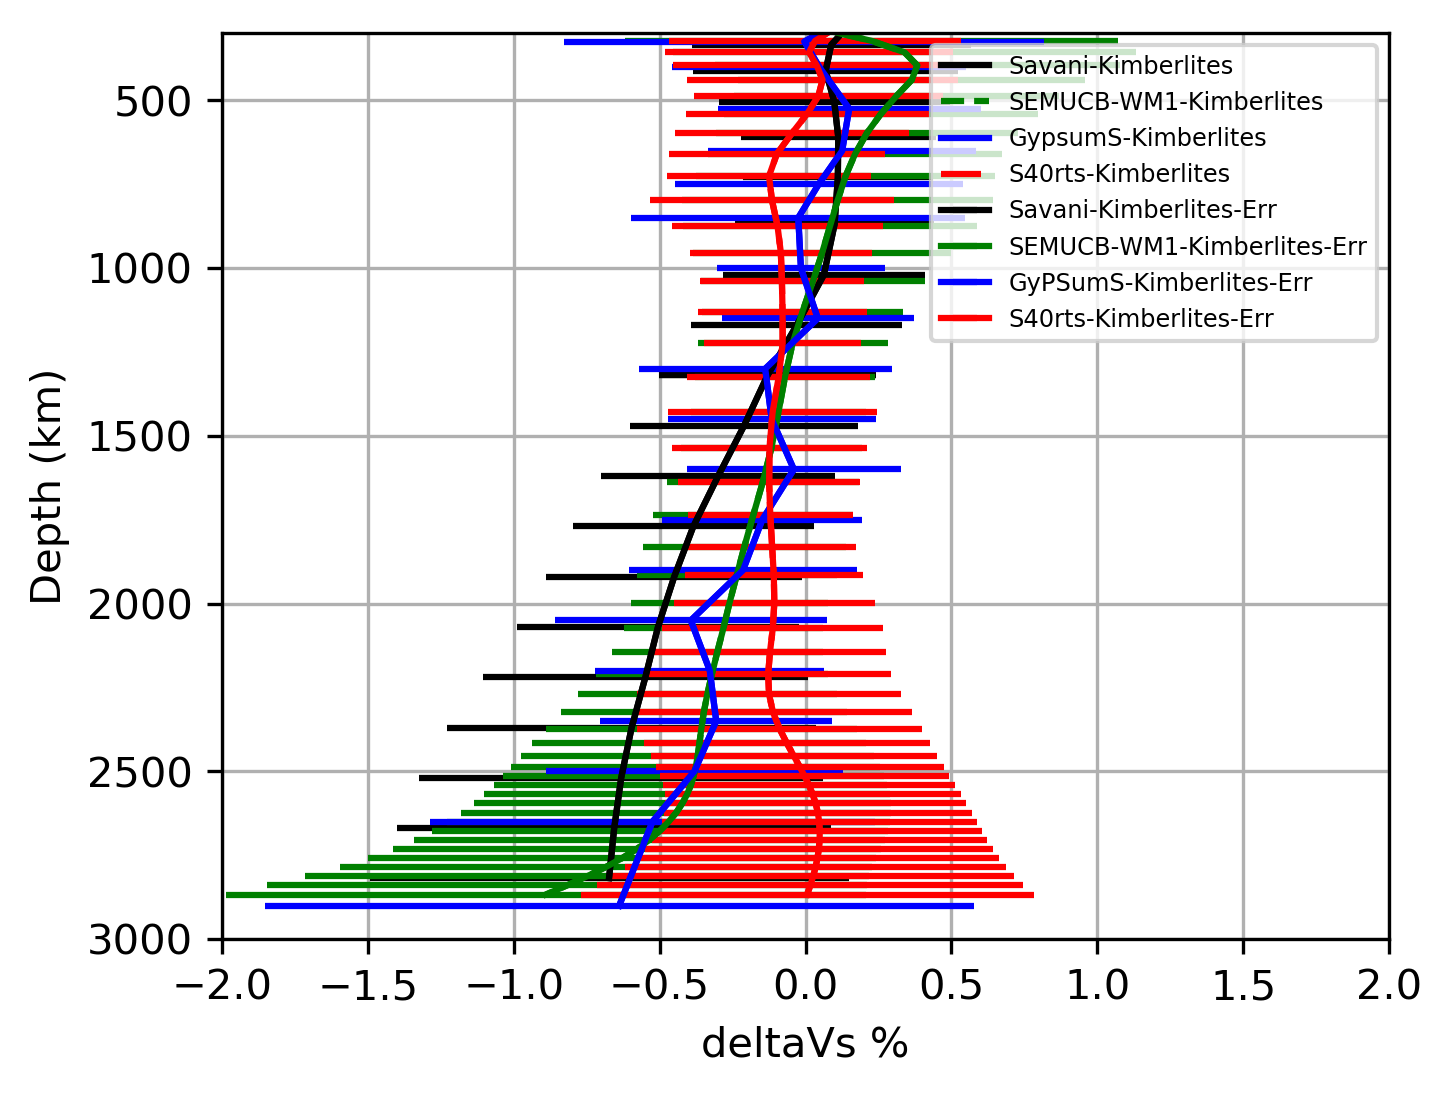

In [23]:
# f=open('/Users/omer/Documents/Data_Tomography_Geology/HMSL_S_depths.txt','r')
# DEPTHLIST=[]
# for line in f:
#     DEPTHLIST.append(line.strip())

# df=pd.DataFrame(Kimberlites_Below_hmsl_s.reshape(679,18))
# plt.plot(df.mean()-np.asarray(hmsl_s_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='orange',label="HMSL_S-Kimberlites",linestyle=':')
# # plt.plot(hmsl_s_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='k',linestyle='dashed',label="HMSL_S-global-mean")

f=open('/Users/omer/Documents/Data_Tomography_Geology/savani_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimb_below_Savani.reshape(679,29))
# plt.plot(df.mean(),np.asarray(DEPTHLIST,dtype="float64"),c='black',label="Savani-Kimberlites",linestyle='-')
# plt.plot(SavaniMean,np.asarray(DEPTHLIST,dtype="float64"),c='b',linestyle='dashed',label="Savani-global-mean")

plt.plot(df.mean()-np.asarray(SavaniMean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),
         c='black',label="Savani-Kimberlites",linestyle='-')

f=open('/Users/omer/Documents/Programming/GMT_Scripts/Savani_std_M21.txt','r')
STD=[]
for line in f:
    STD.append(line.strip())

STD=np.asarray(STD,dtype="float64")

plt.errorbar(df.mean()-np.asarray(SavaniMean,dtype='float64'),
             np.asarray(DEPTHLIST,dtype="float64"),xerr=STD,
             c='black',label="Savani-Kimberlites-Err",linestyle='-')




# f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean/smean_depths.txt','r')
# DEPTHLIST=[]
# for line in f:
#     DEPTHLIST.append(line.strip())

# df=pd.DataFrame(Kimberlites_Below_smean.reshape(679,29))
# plt.plot(df.mean()-np.asarray(smean_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='black',label="Smean-Kimberlites",linestyle=':')
# # plt.plot(smean_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='orange',linestyle='dashed',label="Smean-global-mean")


# f=open('/Users/omer/Documents/Data_Tomography_Geology/Tomography_models/smean2/smean2_depths.txt','r')
# DEPTHLIST=[]
# for line in f:
#     DEPTHLIST.append(line.strip())

# df=pd.DataFrame(Kimberlites_Below_smean2.reshape(679,58))
# plt.plot(df.mean()-np.asarray(smean2_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='black',label="Smean2-Kimberlites",linestyle='--')
# # plt.plot(smean2_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='purple',linestyle='dashed',label="Smean2-global-mean")



f=open('/Users/omer/Documents/Data_Tomography_Geology/semucb-wm1_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimberlites_Below_semucb_wm1.reshape(679,65))
plt.plot(df.mean()-np.asarray(semucb_wm1_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),
         c='green',label="SEMUCB-WM1-Kimberlites", linestyle='--')
# plt.plot(semucb_wm1_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='green',linestyle='dashed',label="SEMUCB-WM1-global-mean")

f=open('/Users/omer/Documents/Programming/GMT_Scripts/semucb_std_M21.txt','r')
STD=[]
for line in f:
    STD.append(line.strip())
    
STD=np.asarray(STD,dtype="float64")

plt.errorbar(df.mean()-np.asarray(semucb_wm1_Mean,dtype='float64'),
             np.asarray(DEPTHLIST,dtype="float64"),xerr=STD,
             c='green',label="SEMUCB-WM1-Kimberlites-Err",linestyle='-')




f=open('/Users/omer/Documents/Data_Tomography_Geology/GypsumS_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimberlites_Below_GypsumS.reshape(679,22))
plt.plot(df.mean()-np.asarray(GypsumS_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),
         c='blue',label="GypsumS-Kimberlites", linestyle='-')
# plt.plot(GypsumS_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='cyan',linestyle='dashed',label="GypsumS-global-mean")

f=open('/Users/omer/Documents/Programming/GMT_Scripts/Gypsums_std_M21.txt','r')
STD=[]
for line in f:
    STD.append(line.strip())
STD=np.asarray(STD,dtype="float64")

plt.errorbar(df.mean()-np.asarray(GypsumS_Mean,dtype='float64'),
             np.asarray(DEPTHLIST,dtype="float64"),xerr=STD,
             c='blue',label="GyPSumS-Kimberlites-Err",linestyle='-')



f=open('/Users/omer/Documents/Data_Tomography_Geology/s40rts_depths.txt','r')
DEPTHLIST=[]
for line in f:
    DEPTHLIST.append(line.strip())

df=pd.DataFrame(Kimberlites_Below_s40rts.reshape(679,65))
plt.plot(df.mean()-np.asarray(s40rts_Mean,dtype='float64'),np.asarray(DEPTHLIST,dtype="float64"),c='red',
         label="S40rts-Kimberlites",linestyle='-.')
# plt.plot(s40rts_Mean,np.asarray(DEPTHLIST,dtype="float64"),c='red',linestyle='dashed',label="S40rts-global-mean")

f=open('/Users/omer/Documents/Programming/GMT_Scripts/s40rts_std_M21.txt','r')
STD=[]
for line in f:
    STD.append(line.strip())

STD=np.asarray(STD,dtype="float64")

plt.errorbar(df.mean()-np.asarray(s40rts_Mean,dtype='float64'),
             np.asarray(DEPTHLIST,dtype="float64"),xerr=STD,
             c='red',label="S40rts-Kimberlites-Err",linestyle='-')

# plt.fill(df.mean()-np.asarray(s40rts_Mean,dtype='float64')-STD,
#                  df.mean()-np.asarray(s40rts_Mean,dtype='float64')+STD,
#                  np.asarray(DEPTHLIST,dtype="float64"),alpha=0.5)

plt.plot()


# plt.title('Kimberlites x hmsl.s')    
plt.gca().invert_yaxis()
plt.xlabel("deltaVs %")
plt.ylabel("Depth (km)")
plt.gca().figure.dpi=300   
plt.xlim(-2,2)
# plt.xticks([-1.2,-1.0,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4])
plt.ylim(3000,300)
plt.legend(fontsize='xx-small')
plt.grid()
plt.gca().set_aspect(1.15e-3)
# plt.show()
plt.savefig('Fig1-NG-Reviews-With_errorBars-M21.pdf',dpi=300)
# plt.savefig('Tomography_vsDepth_Shifted_by_mean-18July2022.png',dpi=300)


    
        

In [17]:
Kimberlites_Below_smean2.shape

(679, 58, 1)

In [14]:
Kimberlites_Below_hmsl_s

array([[[ 2.08356357],
        [ 2.87393618],
        [-0.2611064 ],
        ...,
        [-0.26864138],
        [-0.35723117],
        [-0.95696163]],

       [[-1.5410111 ],
        [ 2.49174023],
        [-1.16344821],
        ...,
        [-0.32263499],
        [-0.68924612],
        [-0.91383934]],

       [[ 2.0909667 ],
        [ 2.97446465],
        [ 0.01253613],
        ...,
        [-0.21185473],
        [ 0.10221533],
        [ 0.10357671]],

       ...,

       [[-0.59847802],
        [ 4.58617592],
        [ 0.28551286],
        ...,
        [ 0.13210244],
        [ 0.46784762],
        [-0.3087801 ]],

       [[ 1.0529635 ],
        [ 5.3930645 ],
        [ 3.2985487 ],
        ...,
        [-0.99971223],
        [-0.74069703],
        [-1.12638915]],

       [[ 0.77476168],
        [ 1.24339962],
        [-1.19275999],
        ...,
        [-0.57278204],
        [-0.16625984],
        [ 0.16602488]]])